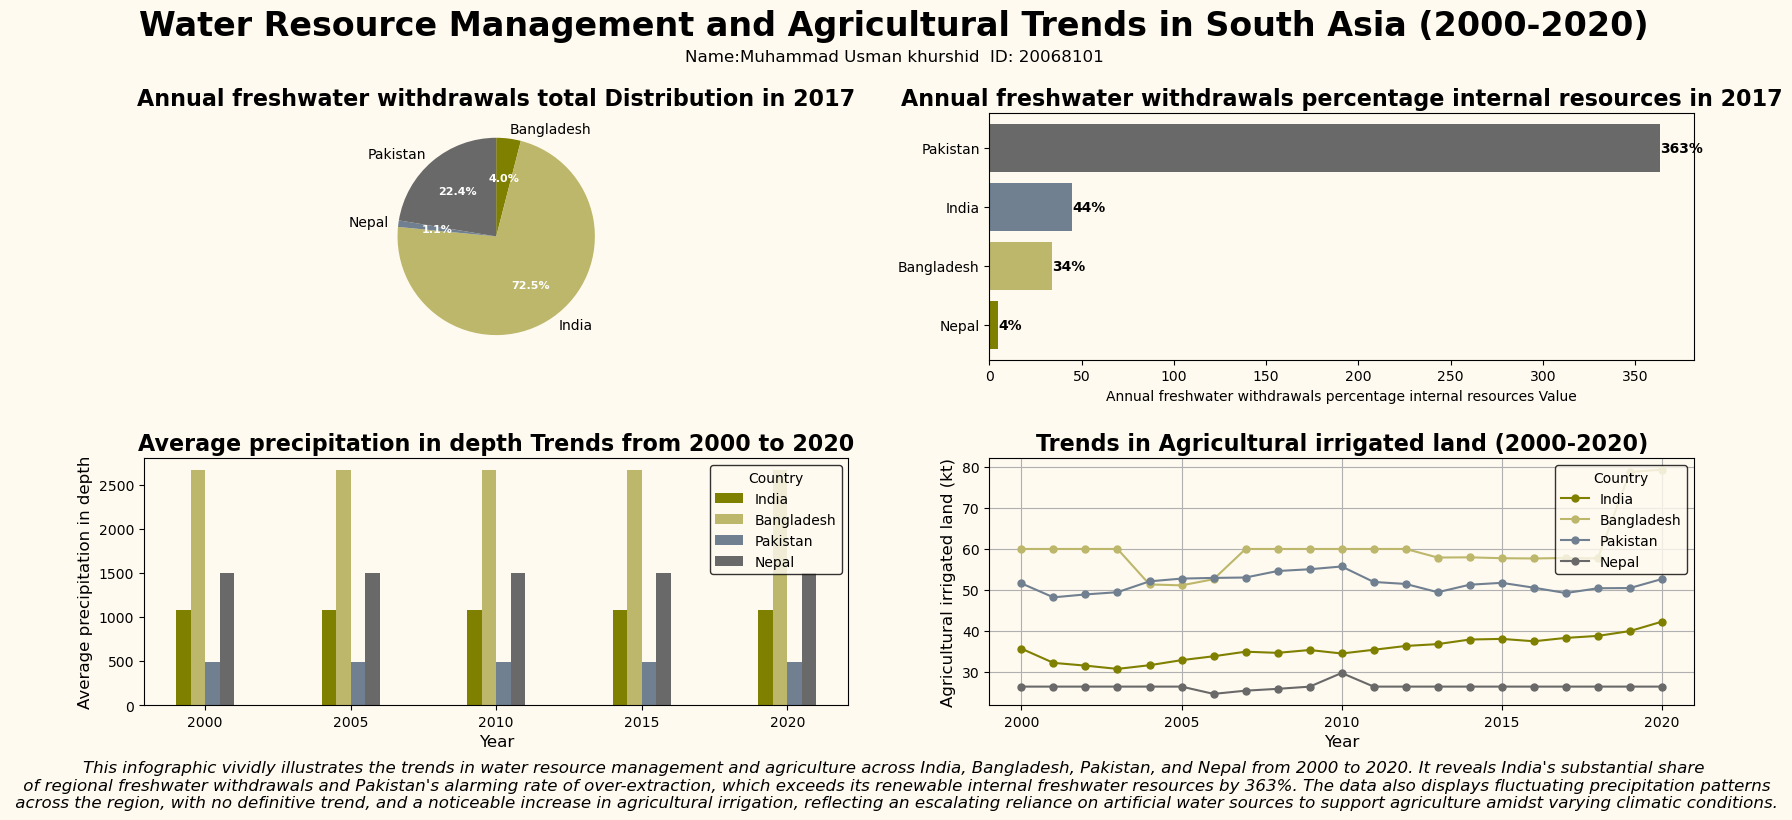

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def analyze_environmental_data():
    """Analyzes environmental data from a provided CSV file."""
    environmental_data = pd.read_csv('World_Climate data.csv', skiprows=4)
    environmental_data.drop(columns=['Indicator Code', 'Country Code'], inplace=True)
    environmental_data.rename(
        columns={
            'Country Name': 'Country',
            'Indicator Name': 'Metric'
        }, inplace=True
    )

    # Update year column names and convert data to numeric type
    for col in environmental_data.columns:
        if 'YR' in col:
            new_col_name = col.split('[')[0].strip()
            environmental_data.rename(columns={col: new_col_name}, inplace=True)
            environmental_data[new_col_name] = pd.to_numeric(
                environmental_data[new_col_name], errors='coerce'
            )

    # Mapping of detailed indicators to simplified names
    metric_mapping = {
        'Annual freshwater withdrawals, total (billion cubic meters)': 'Annual freshwater withdrawals total',
        'Annual freshwater withdrawals, total (% of internal resources)': 'Annual freshwater withdrawals percentage internal resources',
        'Average precipitation in depth (mm per year)': 'Average precipitation in depth',
        'Agricultural irrigated land (% of total agricultural land)': 'Agricultural irrigated land'
    }
    environmental_data['Metric'] = environmental_data['Metric'].map(metric_mapping)
    relevant_metrics = list(metric_mapping.values())
    environmental_data = environmental_data[environmental_data['Metric'].isin(relevant_metrics)]
    
    return environmental_data

def plot_distribution_pie_chart(ax, data_frame, metric, year='2017'):
    """Plots a pie chart to show energy distribution for selected countries in a specific year."""
    target_countries = ['India', 'Bangladesh', 'Pakistan', 'Nepal']
    data_subset = data_frame[data_frame['Metric'] == metric]
    data_subset = data_subset[data_subset['Country'].isin(target_countries)]
    data_subset = data_subset[['Country', year]].set_index('Country')
    
    # Convert data to numeric values, replace NaNs with 0
    data_subset[year] = pd.to_numeric(data_subset[year], errors='coerce').fillna(0)
    
    # Avoid plotting if the data only contains zeros
    if data_subset[year].sum() == 0:
        print("No data available for plotting.")
        return
    
    chart_colors = ['olive', 'darkkhaki', 'slategray', 'dimgray']
    wedges, texts, autotexts = ax.pie(
        data_subset[year], labels=data_subset.index, autopct='%1.1f%%',
        colors=chart_colors, startangle=90, counterclock=False
    )
    ax.set_title(f'{metric} Distribution in {year}', fontsize=16, fontweight='bold')
    plt.setp(autotexts, size=8, weight='bold', color='white')

    ax.figure.canvas.draw()  # Update the figure to ensure the plot reflects the latest data


def plot_bar_chart(ax, data_frame, metric, years=[2000, 2005, 2010, 2015, 2020]):
    """Plots a vertical bar chart that compares energy-related metrics across selected years."""
    selected_countries = ['India', 'Bangladesh', 'Pakistan', 'Nepal']
    year_columns = [str(year) for year in years]
    relevant_data = data_frame[data_frame['Metric'] == metric]
    relevant_data = relevant_data[relevant_data['Country'].isin(selected_countries)]
    relevant_data = relevant_data[['Country'] + year_columns].set_index('Country')
    bar_width = 0.1
    color_palette = ['olive', 'darkkhaki', 'slategray', 'dimgray']

    for i, country in enumerate(selected_countries):
        country_data = relevant_data.loc[country, year_columns]
        ax.bar(
            [x + i * bar_width for x in range(len(years))], country_data, label=country,
            color=color_palette[i], width=bar_width
        )

    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} Trends from {years[0]} to {years[-1]}', fontsize=16, fontweight='bold')
    ax.legend(title='Country')
    ax.set_xticks([x + (len(selected_countries) - 1) * bar_width / 2 for x in range(len(years))])
    ax.set_xticklabels(years)


    
def plot_horizontal_indicator_bars(ax, data_frame, indicator):
    """
    Plots a horizontal bar chart for the specified indicator from a DataFrame,
    highlighting data for key countries with unique colors for each bar.
    """
    # List of key countries for the data visualization
    key_countries = ['India', 'Bangladesh', 'Pakistan', 'Nepal']
    filtered_data = data_frame[data_frame['Metric'] == indicator]
    filtered_data = filtered_data.drop(columns=['Metric'])

    # Sort the data for better visualization and handle missing values
    filtered_data.sort_values(by=['2017'], inplace=True)
    filtered_data = filtered_data[filtered_data['Country'].isin(key_countries)][['Country', '2017']].set_index('Country')
    filtered_data['2017'].fillna(0, inplace=True)

    # Define bar colors
    bar_colors = ['olive', 'darkkhaki', 'slategray', 'dimgray']
    bars = ax.barh(filtered_data.index, filtered_data['2017'], color=bar_colors)
    
    # Setup labels and title for the chart
    ax.set_xlabel(f'{indicator} Value')
    ax.set_title(f'{indicator} in 2017', fontsize=16, fontweight='bold')
    
    # Annotate each bar with its value
    for bar in bars:
        ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{int(bar.get_width())}%',
                ha='left', va='center', fontweight='bold')



def plot_line_trends(ax, data_frame, metric):
    """Plots a line chart illustrating the evolution of energy production over time for specified countries."""
    important_countries = ['India', 'Bangladesh', 'Pakistan', 'Nepal']
    years = [str(year) for year in range(2000, 2021)]
    energy_metrics = data_frame[data_frame['Metric'] == metric]
    line_colors = ['olive', 'darkkhaki', 'slategray', 'dimgray']

    for i, country in enumerate(important_countries):
        country_data = energy_metrics[energy_metrics['Country'] == country]
        if not country_data.empty:
            # Compute the mean of the year columns and use it to fill NaN values
            mean_values = country_data[years].mean(axis=1)
            annual_values = country_data.iloc[0][years].fillna(mean_values.iloc[0])
            ax.plot(
                years, annual_values, label=country, marker='o',
                linestyle='-', markersize=5, color=line_colors[i]
            )

    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel(f'{metric} (kt)', fontsize=12)
    ax.set_title(f'Trends in {metric} (2000-2020)', fontsize=16, fontweight='bold')
    ax.legend(title='Country')
    ax.set_xticks(years[::5])  # Setting x-ticks every 5 years for better readability
    ax.grid(True)


# Main script to create plots
df = analyze_environmental_data()
fig = plt.figure(figsize=(20, 8), facecolor='floralwhite')
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 4], height_ratios=[1, 1])
plt.subplots_adjust(top=0.85)
fig.suptitle('Water Resource Management and Agricultural Trends in South Asia (2000-2020)', fontsize=24, fontweight='bold')
fig.text(0.5, 0.92, "Name:Muhammad Usman khurshid  ID: 20068101", ha='center', va='center', fontsize=12)
ax1 = plt.subplot(gs[0])
ax1.set_facecolor('floralwhite')
plot_distribution_pie_chart(ax1, df, 'Annual freshwater withdrawals total')

ax2 = plt.subplot(gs[1])
ax2.set_facecolor('floralwhite')
plot_horizontal_indicator_bars(ax2, df, 'Annual freshwater withdrawals percentage internal resources')

ax3 = plt.subplot(gs[2])
ax3.set_facecolor('floralwhite')
plot_bar_chart(ax3, df, 'Average precipitation in depth')
# Customizing legend for Bar Chart
legend = ax3.legend(title='Country', facecolor='floralwhite', edgecolor='black')
ax4 = plt.subplot(gs[3])
ax4.set_facecolor('floralwhite')
# Customizing legend for Line Plot

plot_line_trends(ax4, df, 'Agricultural irrigated land')
legend = ax4.legend(title='Country', facecolor='floralwhite', edgecolor='black')
plt.subplots_adjust(wspace=0.2, hspace=0.4)
summary_text = (
    "This infographic vividly illustrates the trends in water resource management and agriculture across India, Bangladesh, "
    "Pakistan, and Nepal from 2000 to 2020. It reveals India's substantial share\n of regional freshwater withdrawals and Pakistan's "
    "alarming rate of over-extraction, which exceeds its renewable internal freshwater resources by 363%. The data also displays "
    "fluctuating precipitation patterns\n across the region, with no definitive trend, and a noticeable increase in agricultural "
    "irrigation, reflecting an escalating reliance on artificial water sources to support agriculture amidst varying climatic conditions."
)
fig.text(0.5, 0.01, summary_text, ha='center', va='center', fontsize=12, style='italic')
plt.savefig('20068101.png', dpi=300, bbox_inches='tight')
